<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>NLP with Deep Learning for Everyone</h1>
<h1>Text Classification</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import gzip
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np
np.random.seed(42)

import matplotlib
import matplotlib.pyplot as plt 

from tqdm import tqdm

import keras
import tensorflow as tf
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Embedding
from keras_preprocessing import sequence

import watermark

%load_ext watermark
%matplotlib inline

2023-09-13 16:55:07.288871: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.10.0

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 22.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: 1be5202dab64d861a7118c0e0a9f26db1ea5f758

watermark          : 2.4.2
pandas             : 1.5.3
matplotlib         : 3.7.2
keras_preprocessing: 1.1.2
keras              : 2.12.0
numpy              : 1.23.5
tensorflow         : 2.12.0



Load default figure style

In [3]:
plt.style.use('d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


# IMDB Dataset

In [4]:
top_words = 10_000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

Each word is associated with a unique ID. We can easily obtain the dictionary mapping words to IDs

In [5]:
word_dict = imdb.get_word_index()

So we can check what the id of each word is

In [6]:
word_dict['casting']

970

In [7]:
word_dict['director']

164

We also invert the index so that we can recover the original text. A few special tokens are reserved at the beginning of the id range

In [8]:
word_list = ["<PAD>", "<START>", "<UNK>", "<UNUSED>"]
word_list.extend([k for k, v in sorted(word_dict.items(), key = lambda x: x[1])])
word_list = np.array(word_list)

In [9]:
X_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [10]:
" ".join(word_list[X_train[0]])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

Each review has associated with it a value of 0 or 1.

In [11]:
set(y_train)

{0, 1}

So the corresponding rating for review is

In [12]:
y_train[0]

1

1 means positive, while 0 means negative

In [13]:
" ".join(word_list[X_train[4]])

"<START> worst mistake of my life br br i picked this movie up at target for 5 because i figured hey it's sandler i can get some cheap laughs i was wrong completely wrong mid way through the film all three of my friends were asleep and i was still suffering worst plot worst script worst movie i have ever seen i wanted to hit my head up against a wall for an hour then i'd stop and you know why because it felt damn good upon bashing my head in i stuck that damn movie in the <UNK> and watched it burn and that felt better than anything else i've ever done it took american psycho army of darkness and kill bill just to get over that crap i hate you sandler for actually going through with this and ruining a whole day of my life"

In [14]:
y_train[4]

0

Our dataset is split into two equal parts, the training and the testing dataset

In [15]:
print('Shape of training data:', X_train.shape)
print('Shape of test data:', X_test.shape)

Shape of training data: (25000,)
Shape of test data: (25000,)


# Feed Forward Model

We'll start by training a simple FF model without any fancyness. The first step is to padd each instance so that they all have the same size. Here we'll use the first 450 words. If the review is longer, we trucate it, while if its shorter we pad it

In [16]:
max_words = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

In [17]:
" ".join(word_list[X_train[0]])

"<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

## Model Structure

Our model will have an embedding layer to turn our numerical ids into vectors, a hidden dense layer of 32 neurons and ReLu activation followed by an output layer with just one neuron and a sigmoid activation

In [18]:
model = Sequential() # []
model.add(Embedding(top_words, 50, input_length=max_words)) # [].append()
## <==> ##
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In summary:

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 50)           500000    
                                                                 
 flatten (Flatten)           (None, 25000)             0         
                                                                 
 dense (Dense)               (None, 32)                800032    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,300,065
Trainable params: 1,300,065
Non-trainable params: 0
_________________________________________________________________


Next we compile our model using a binary cross entropy loss function and the Adam optimizer

In [20]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

The final step is to fit the model using the training data. We also supply the test data for validation purposes

In [21]:
history = model.fit(X_train, y_train, # Training data
          validation_data=(X_test, y_test), # The testing data for validation
          epochs=10, # How many epochs to train for
          batch_size=128, # The batch size. Gradients are updated after each batch 
          verbose=1) # The level of detail in the output

Epoch 1/10
196/196 [==============================] - 4s 19ms/step - loss: 0.4569 - accuracy: 0.7589 - val_loss: 0.2823 - val_accuracy: 0.8816
Epoch 2/10
196/196 [==============================] - 4s 19ms/step - loss: 0.1477 - accuracy: 0.9486 - val_loss: 0.3350 - val_accuracy: 0.8638
Epoch 3/10
196/196 [==============================] - 4s 20ms/step - loss: 0.0381 - accuracy: 0.9922 - val_loss: 0.3456 - val_accuracy: 0.8766
Epoch 4/10
196/196 [==============================] - 4s 19ms/step - loss: 0.0079 - accuracy: 0.9994 - val_loss: 0.3862 - val_accuracy: 0.8740
Epoch 5/10
196/196 [==============================] - 4s 21ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.4184 - val_accuracy: 0.8743
Epoch 6/10
196/196 [==============================] - 4s 21ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.4362 - val_accuracy: 0.8762
Epoch 7/10
196/196 [==============================] - 4s 22ms/step - loss: 8.4490e-04 - accuracy: 1.0000 - val_loss: 0.4539 - val_accuracy: 0.

Small utility function to display the results

In [22]:
def plot_history(history):    
    fig, ax_lst = plt.subplots(1, 2, sharex=True, sharey=True)

    epochs = np.array(history.epoch) + 1
    
    ax_lst[0].plot(epochs, history.history['loss'], label='Training')
    ax_lst[0].plot(epochs, history.history['val_loss'], label='Testing')
    ax_lst[0].set_ylabel('Loss')
    ax_lst[0].set_xlabel('Epoch')
    ax_lst[0].set_xticks(epochs)
    
    best_epoch = np.argmin(history.history['val_loss']) + 1
    ax_lst[0].axvline(x=best_epoch, linestyle=':', color=colors[2])
    ax_lst[0].legend()
    

    ax_lst[1].plot(epochs, history.history['accuracy'], label='Training')
    ax_lst[1].plot(epochs, history.history['val_accuracy'], label='Testing')
    ax_lst[1].set_ylabel('Accuracy')
    ax_lst[1].set_xlabel('Epoch')
    ax_lst[1].set_xticks(epochs)
    ax_lst[1].axvline(x=best_epoch, linestyle=':', color=colors[2])

    fig.tight_layout()

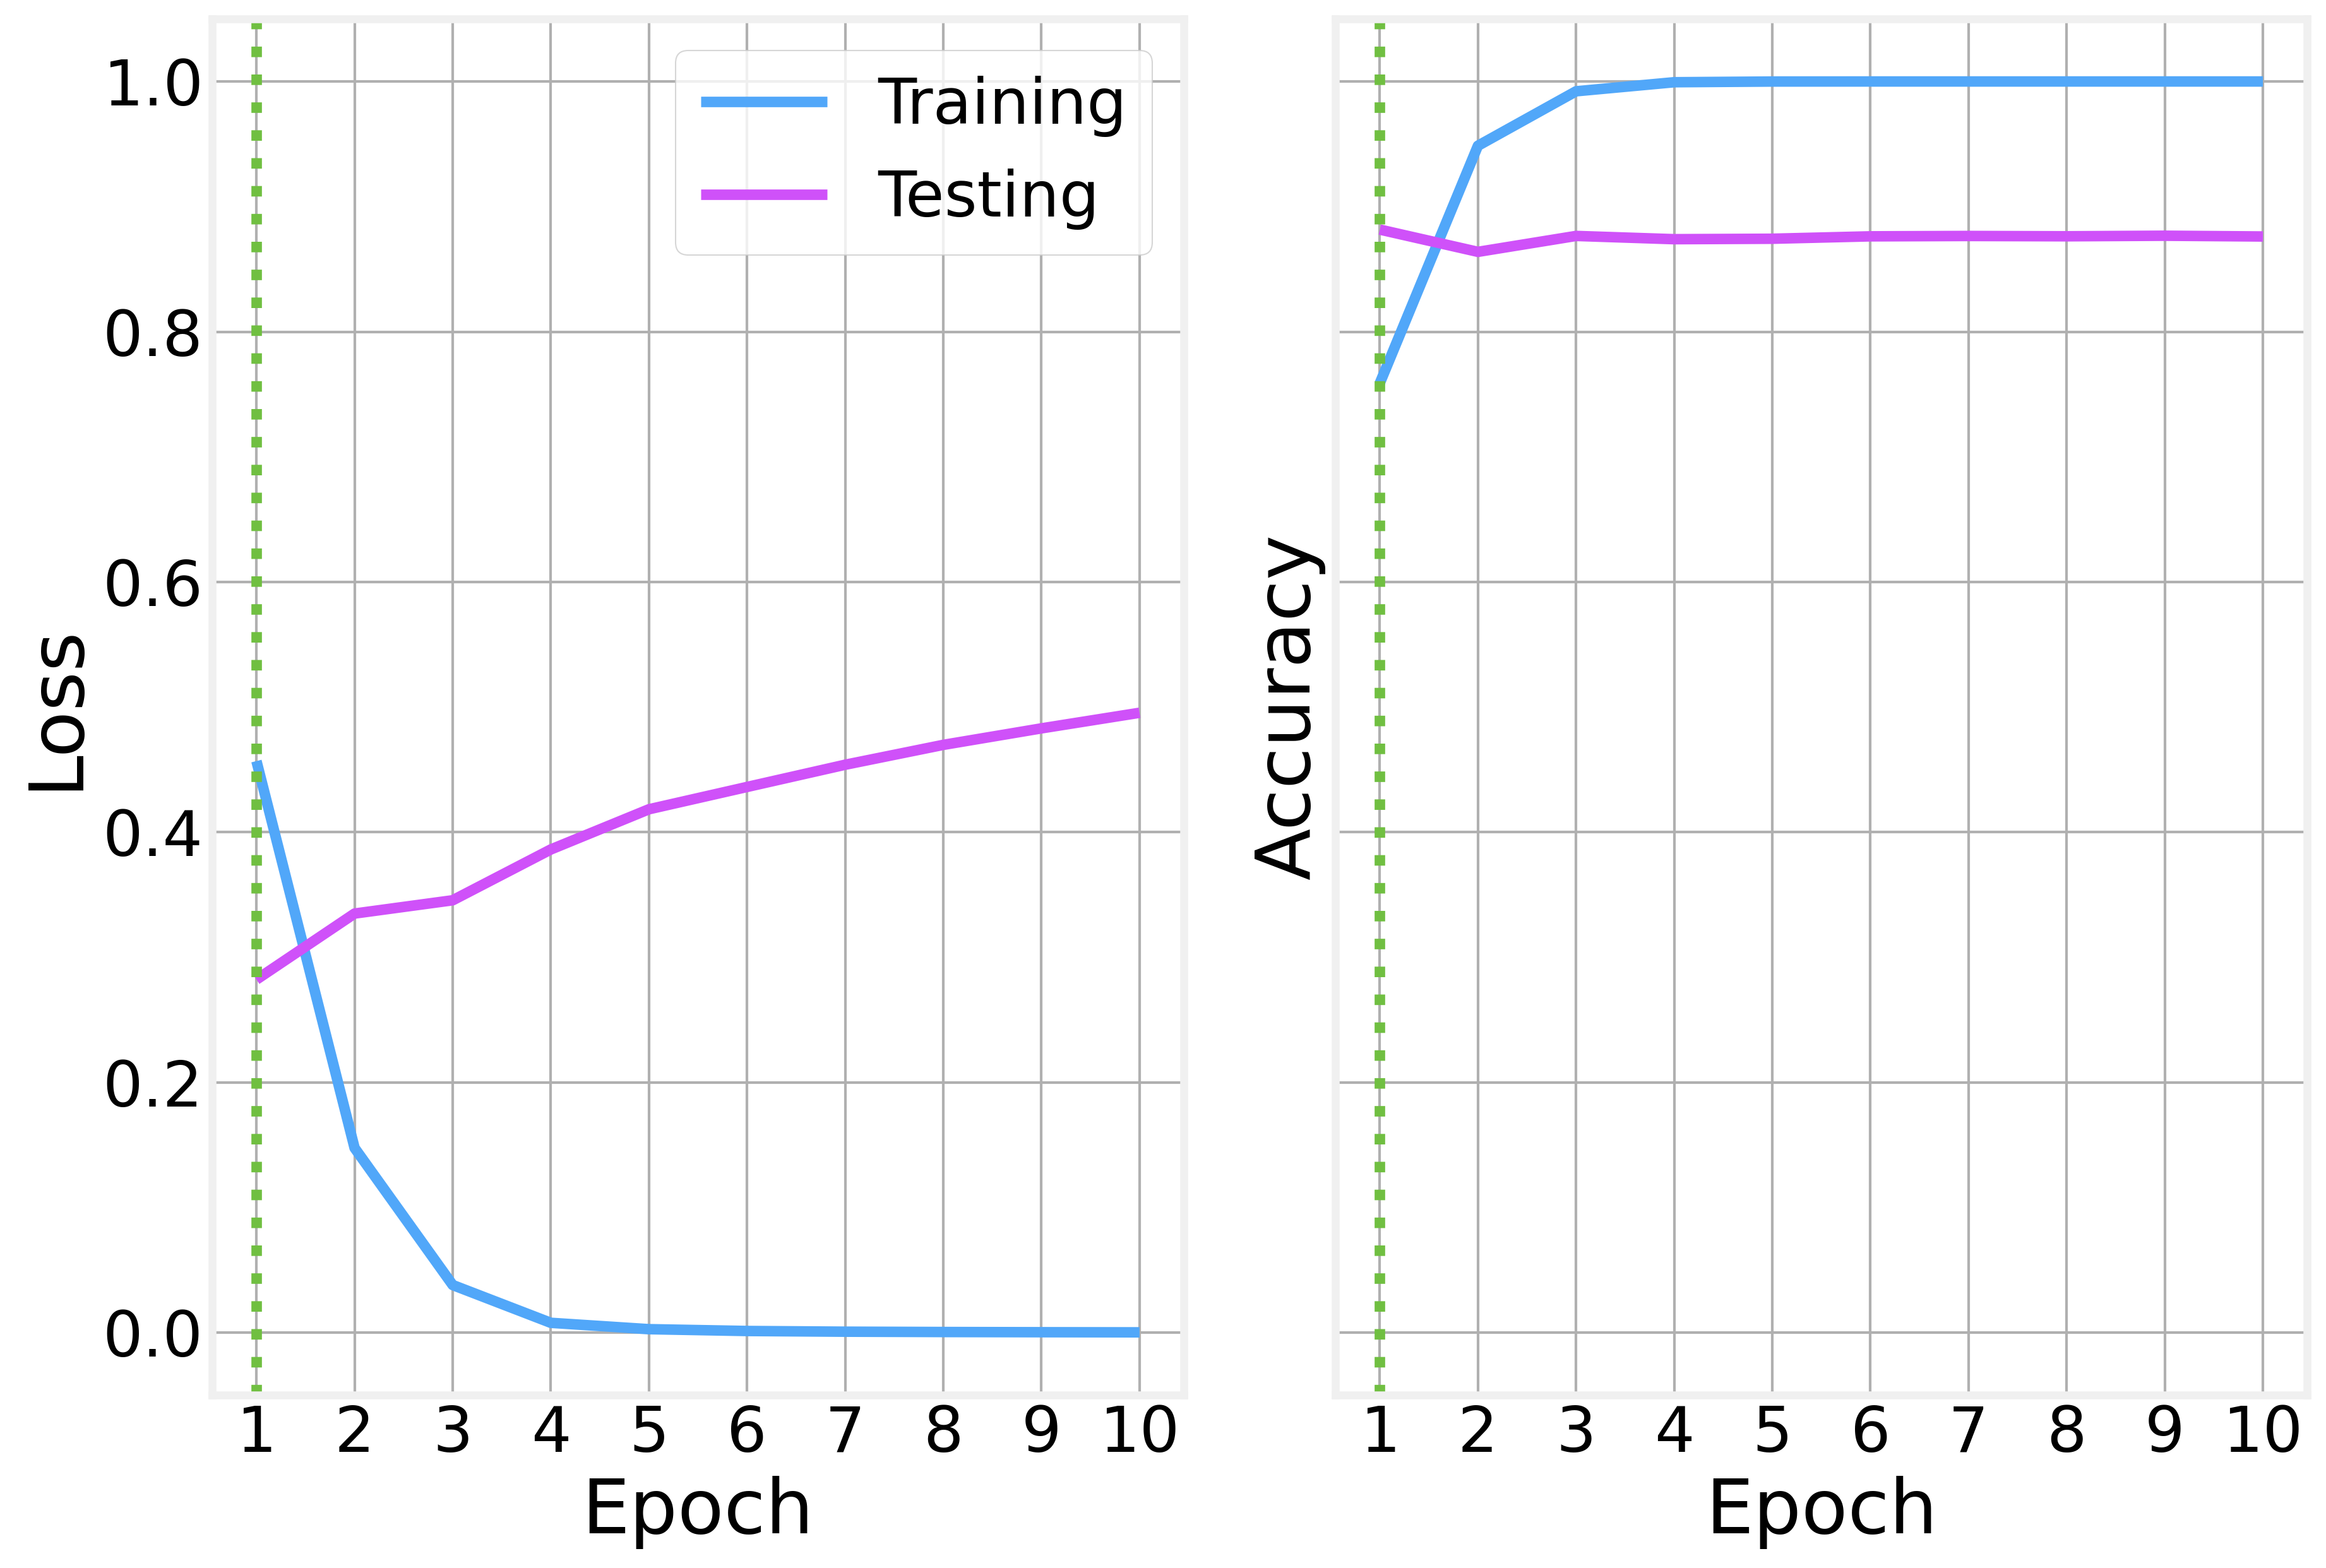

In [23]:
plot_history(history)

Looks like we are overfitting the data after just a few epochs

# Convolutional Model

Now we add a convolution layer between the embedding layer and the dense layer

In [24]:
model = Sequential()
model.add(Embedding(top_words, 50, input_length=max_words))
## <==> ##
model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling1D())
## <==> ##
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

Compile and fit the model

In [25]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 50)           500000    
                                                                 
 conv1d (Conv1D)             (None, 500, 32)           4832      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 250, 32)          0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 8000)              0         
                                                                 
 dense_2 (Dense)             (None, 32)                256032    
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                      

In [26]:
history = model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), # The testing data for validation
          epochs=10, # How many epochs to train for
          batch_size=128, # The batch size. Gradients are updated after each batch 
          verbose=1) # The level of detail in the output

Epoch 1/10
196/196 [==============================] - 12s 60ms/step - loss: 0.4684 - accuracy: 0.7475 - val_loss: 0.2916 - val_accuracy: 0.8791
Epoch 2/10
196/196 [==============================] - 12s 60ms/step - loss: 0.1989 - accuracy: 0.9228 - val_loss: 0.2863 - val_accuracy: 0.8818
Epoch 3/10
196/196 [==============================] - 12s 62ms/step - loss: 0.1246 - accuracy: 0.9569 - val_loss: 0.3165 - val_accuracy: 0.8772
Epoch 4/10
196/196 [==============================] - 13s 65ms/step - loss: 0.0750 - accuracy: 0.9775 - val_loss: 0.3725 - val_accuracy: 0.8762
Epoch 5/10
196/196 [==============================] - 14s 69ms/step - loss: 0.0380 - accuracy: 0.9910 - val_loss: 0.4692 - val_accuracy: 0.8721
Epoch 6/10
196/196 [==============================] - 13s 67ms/step - loss: 0.0160 - accuracy: 0.9975 - val_loss: 0.5294 - val_accuracy: 0.8704
Epoch 7/10
196/196 [==============================] - 13s 66ms/step - loss: 0.0059 - accuracy: 0.9995 - val_loss: 0.6416 - val_accuracy:

This model takes significantly longer to train, but produces much better results

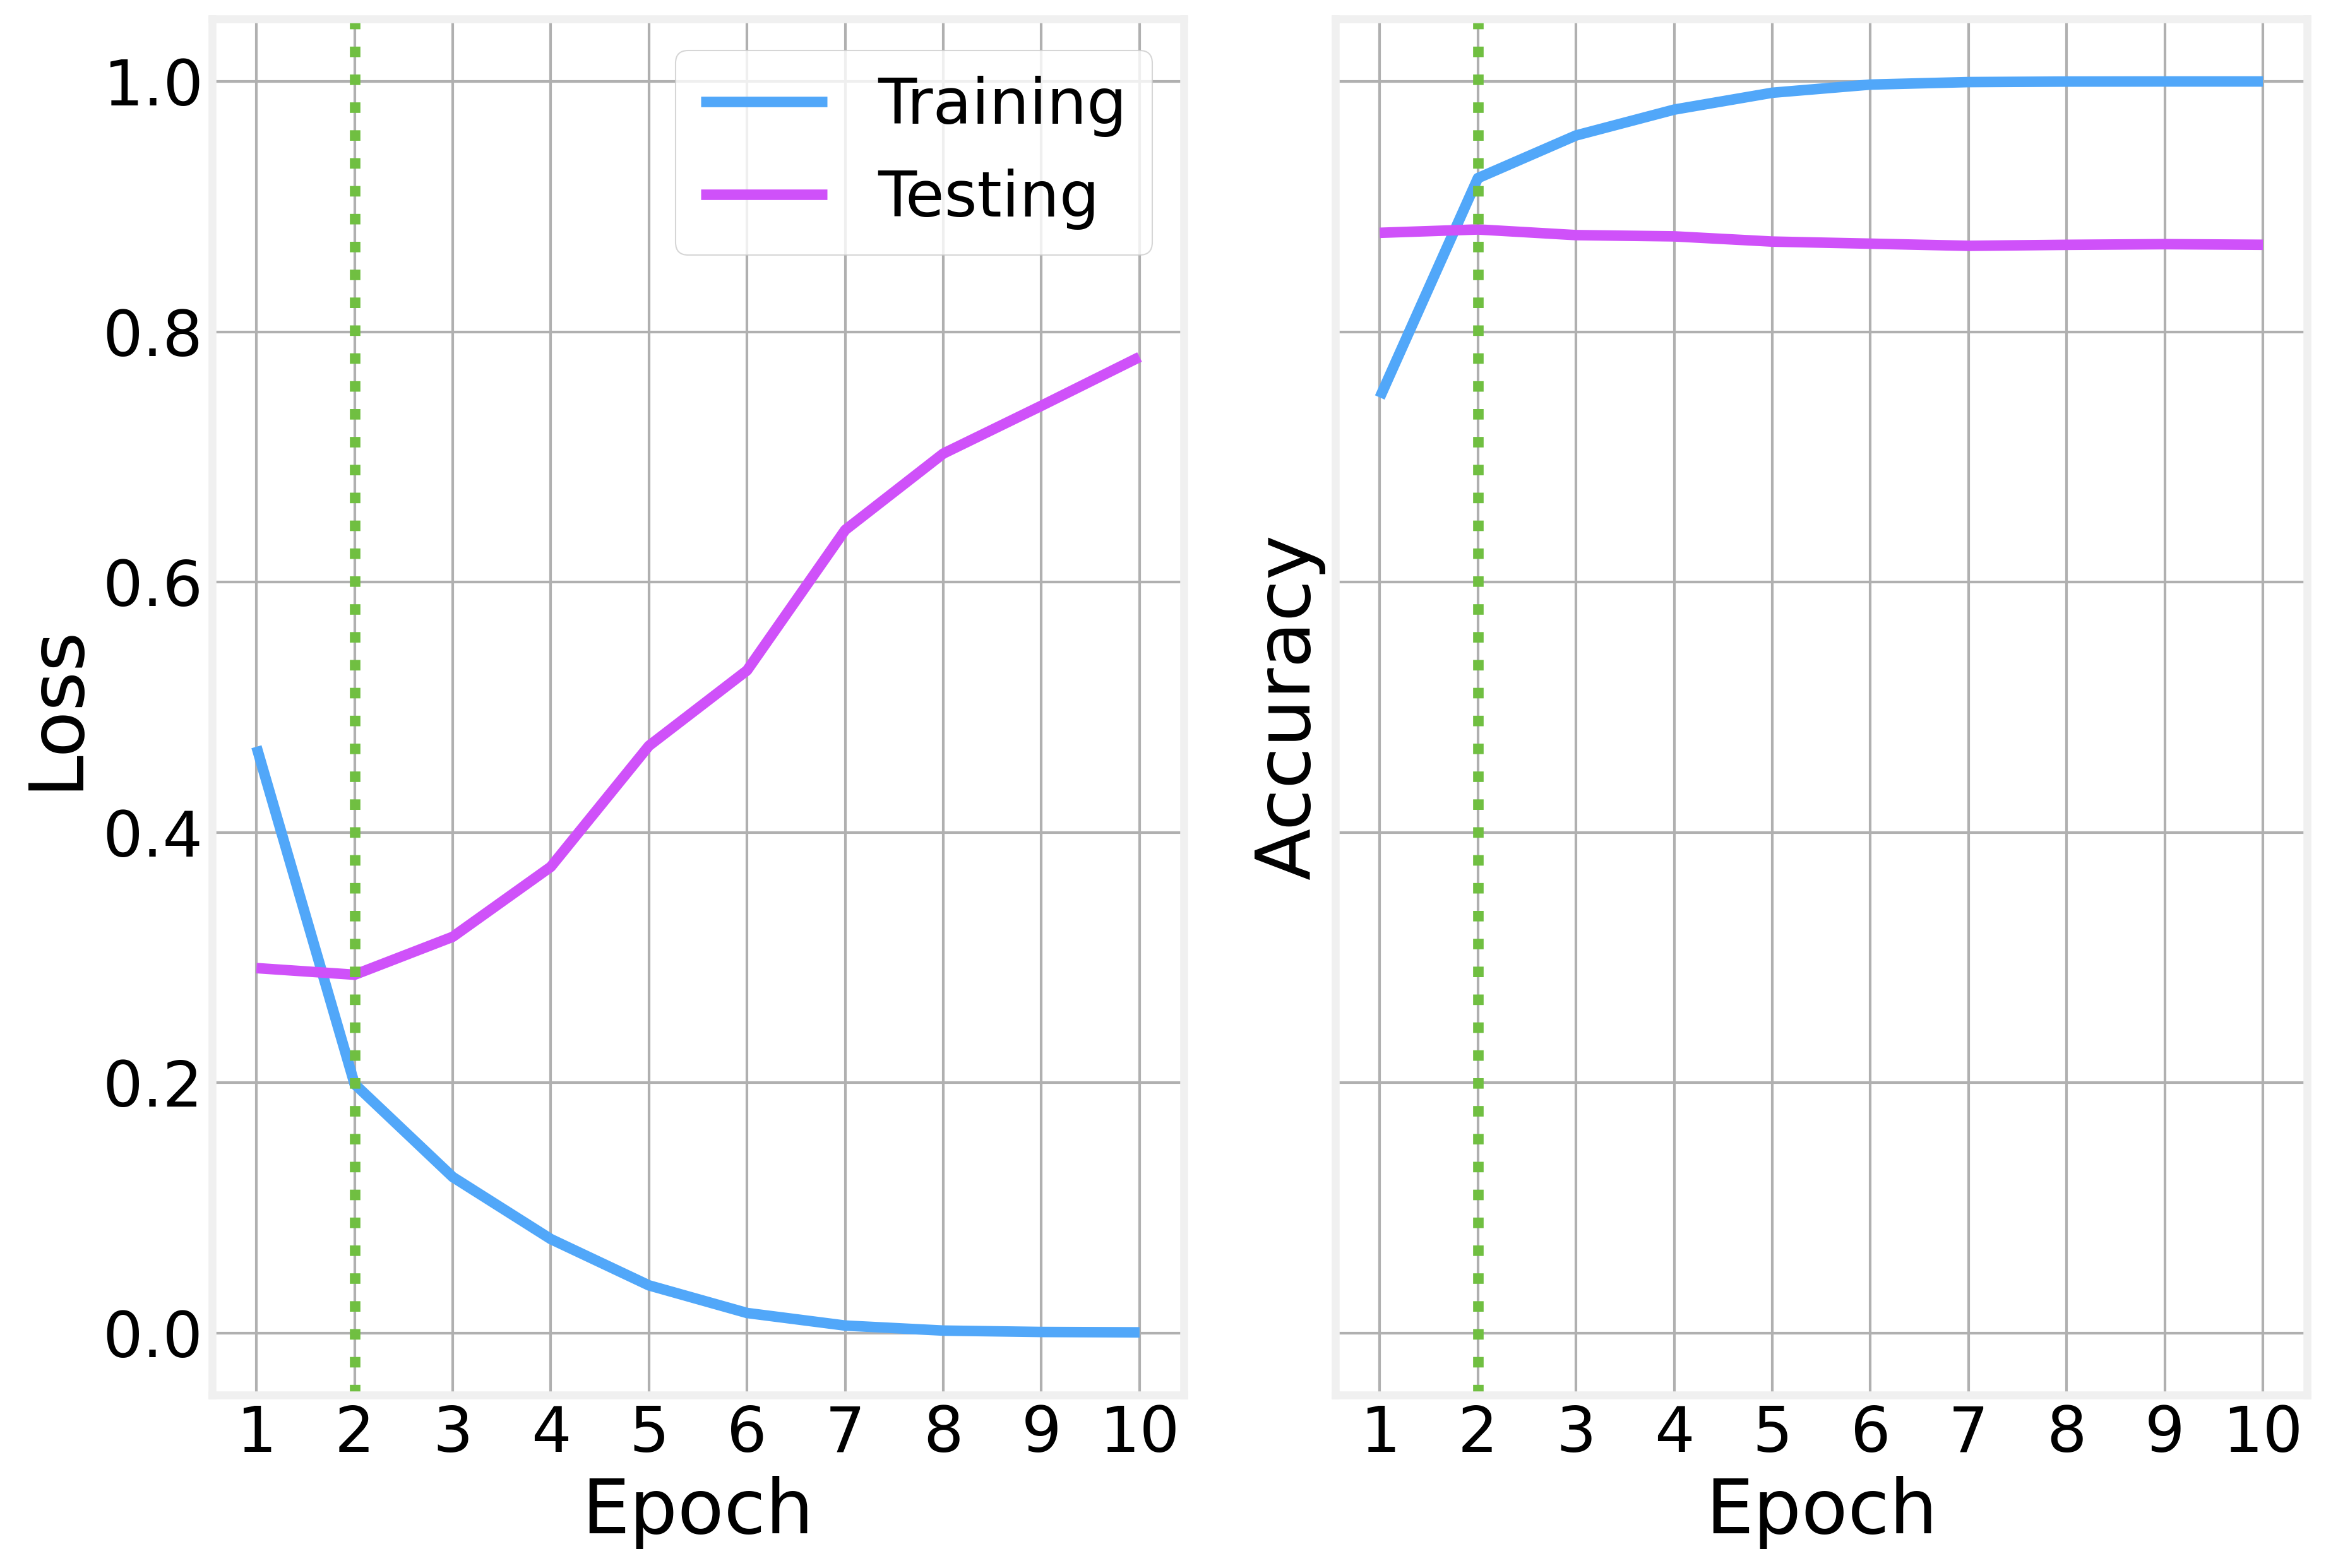

In [27]:
plot_history(history)

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>